In [1]:
using JLD
using HDF5
using Dates
using PyCall
using Random
using PyPlot
using Plots
using Statistics
using BenchmarkTools
using DataFrames, IndexedTables
using Flux: onehot, onehotbatch, softmax, sigmoid
using BSON: @load, @save
using Mosek

system = "manipulation"
include("fileIO.jl")
include("$system/problem.jl")
include("$system/utils.jl")
include("$system/models.jl");

┌ Info: Recompiling stale cache file /home/acauligi/.julia/compiled/v1.2/Convex/Sr0e5.ji for Convex [f65535da-76fb-5f13-bab9-19810c17039a]
└ @ Base loading.jl:1240


In [2]:
ENV["CUDA_VISIBLE_DEVICES"] = "0"

pushfirst!(PyVector(pyimport("sys")."path"), @__DIR__) #need this to be able to source from pytorch.models
torch = pyimport("torch")
torch.cuda.empty_cache()
torchvision = pyimport("torchvision")
np = pyimport("numpy")
sns = pyimport("seaborn")

FFNet = pyimport("pytorch.models")."FFNet" #import custom nn class

PyObject <class 'pytorch.models.FFNet'>

In [3]:
prob_files = [string("$system/data/testdata",ii,".jld") for ii=1:20] #filenames, choose 1-16 for training
prob_dicts = [load(f) for f in prob_files]

# Set problem specific features
prob_features = ["ws"]
bnb_features = []

N_v = 5
N_h = 6
N = N_v * N_h
n_obs = 0

# Calculate length of feature vector
feature_size = 0
if "h" in prob_features feature_size += 1 end
if "r" in prob_features feature_size += 1 end
if "mu" in prob_features feature_size += 1 end
if "ws" in prob_features feature_size += 12 end
feature_size = Int(feature_size)

# Optimization problem handle
prob_handle = getManipulationProb

depth = 3
neurons = 32

training_percentage = 0.9
training_batch_length = Int(round(training_percentage*length(prob_dicts)));

# Identify possible strategies

A dictionary is generated where the keys are indices of integer constraints that would be in violation and the values are (strategy ID, value of first integer assignment corresponding to this strategy).

In [6]:
strategy_dict = Dict{Array{Int64,1}, Array{Int64,1}}()
training_labels = Dict{Array{Float64,1}, Array{Int64,1}}()
count_dict = Dict{Array{Int64,1},Int64}()
assign_dict = Dict{Int64,Array{Int64,1}}()

N_strategies = 0
for dir_idx in 1:training_batch_length
  for prob_idx in 1:length(prob_dicts[dir_idx]["Y"])
    y_true = vectorizeIntegerData(prob_dicts[dir_idx]["Y"][prob_idx])

    if !haskey(strategy_dict,y_true)
        # Strategy unseen
        N_strategies += 1
        strategy_dict[y_true] = [N_strategies; y_true]
        count_dict[y_true] = 1
        assign_dict[N_strategies] = y_true
    else
        count_dict[y_true] += 1
    end

    prob_query = getProblemData(prob_dicts[dir_idx],prob_idx)
    features = construct_prob_features(fill(NaN,1), prob_query["prob_data"], prob_features)
        
    training_labels[features] = strategy_dict[y_true]
  end
end

N_strategies

104

## Plot strategy frequency
Quick plot to visualize how frequently each strategy appears in the training set. Note the "long tail" on this distribution; this implies many strategies may be pruned without a large loss of performance.

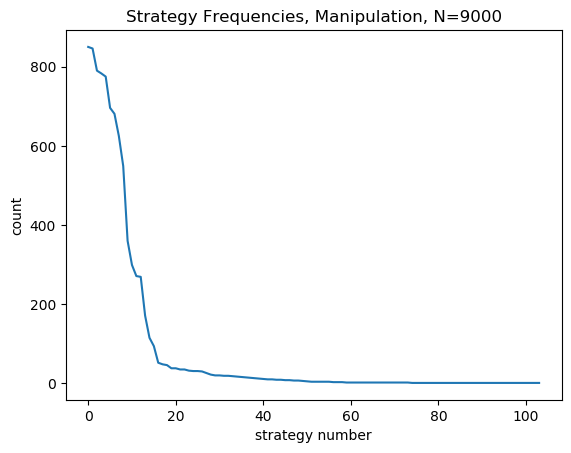

PyObject Text(0.5, 1, 'Strategy Frequencies, Manipulation, N=9000')

In [7]:
PyPlot.plot(sort(collect(values(count_dict)),rev=true))
PyPlot.ylabel("count")
PyPlot.xlabel("strategy number")
PyPlot.title("Strategy Frequencies, Manipulation, N=9000")

# Visualize problem distribution vs. strategy distribution
Another plot to reason about "pruning" strategies. We note for this case 50% of all strategies appear 5 times or fewer in the train set; collectively these strategies are optimal for only 1% of all problems in the dataset.

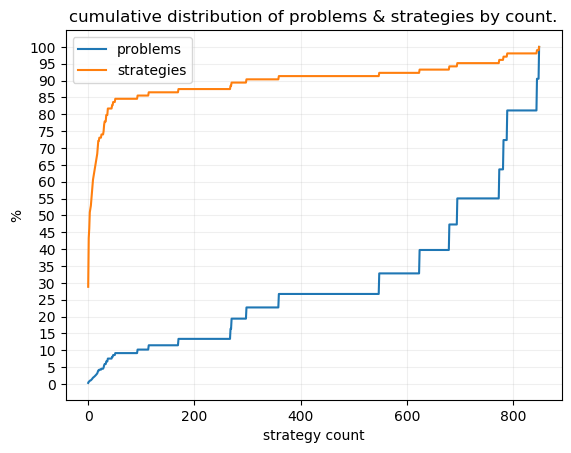

PyObject <matplotlib.legend.Legend object at 0x7fd77ebf3110>

In [9]:
discard_prob_fracs = []
discard_strat_fracs = []
discard_prob_count = 0
discard_strat_count = 0
for i = 1:maximum(collect(values(count_dict)))
    curr_discard = length(findall(collect(values(count_dict)).==i))
    discard_strat_count += curr_discard
    discard_prob_count += i*curr_discard
    push!(discard_prob_fracs, discard_prob_count/9000)
    push!(discard_strat_fracs, discard_strat_count/N_strategies)
end
PyPlot.plot(100*discard_prob_fracs,label="problems")
PyPlot.plot(100*discard_strat_fracs,label="strategies")
PyPlot.grid(alpha=0.2)
PyPlot.yticks(collect(range(0,stop=100,step=5)))
PyPlot.xlabel("strategy count")
PyPlot.ylabel("%")
PyPlot.title("cumulative distribution of problems & strategies by count.")
PyPlot.legend()

In [10]:
#Query fraction of all problems/strategies which have count < thresh
thresh = 5
discard_prob_fracs[thresh], discard_strat_fracs[thresh]

(0.010444444444444444, 0.5192307692307693)

## Save training data

In [13]:
X = zeros(Float64, feature_size, length(keys(training_labels)))
Y = zeros(Int64, N+1, length(keys(training_labels)))

for (key_ct,v) in enumerate(training_labels)
    X[:,key_ct] = v[1]
    Y[:,key_ct] = v[2]
end

In [9]:
fn_model = string("models/mlopt_model_","$(system)_",Dates.format(DateTime(Dates.now()), "yyyymmdd_HHMM"), "_$(depth)-layers_$(neurons)-neurons.jld")

save(fn_model, "system", system, "N_strategies", N_strategies, "feature_size", feature_size,
    "X", X, "Y", Y, "strategy_dict", strategy_dict)

# Train model from terminal
Run `python train_classifier.py ../model/{fn_model}.jld` from the `pytorch` directory.
This step will generate a `{fn_model}.pt` parameter file that will get loaded and used for evaluation in the next section.

In [19]:
fn_model = "models/mlopt_model_manipulation_20200402_1427_3-layers_32-neurons.jld"
fn_dict = load(fn_model)

feature_size = fn_dict["feature_size"]
N_strategies = fn_dict["N_strategies"]
strategy_dict = fn_dict["strategy_dict"];

# Evaluate saved classification model

Do a forward pass using the trained network for each of the test and training samples. This will generate a new file `{fn_model}_classifier_eval.jld` that will be opened for use in the cells below.

In [20]:
classifier_fn = replace(fn_model, ".jld"=>"_classifier.pt")

classifier_model = get_ff_classifier(feature_size, N_strategies; depth=depth,neurons=neurons)
classifier_model.load_state_dict(torch.load(classifier_fn))
n_evals = 1; #number of problems solved by MLOPT at runtime

In [7]:
function solve_with_classifier(prob, Y, prob_dicts, dir_idx, prob_idx, n_evals, optimizer=Mosek.Optimizer(QUIET=true)) 
    prob_query = getProblemData(prob_dicts[dir_idx],prob_idx)
    features = construct_prob_features(fill(NaN,1), prob_query["prob_data"], prob_features)
    input = torch.from_numpy(reshape(features,1,feature_size)).float()

    # Grab the n_evals-best strategies for this problem
    solve_time = @elapsed begin
        scores = classifier_model(input).cpu().detach().numpy()[:];
    end
    ind_max = partialsortperm(scores, 1:n_evals, rev=true)

    # Get integer assignments for each obstacle
    y_strats = [Array{Int64,1}() for _ in 1:n_evals]
    # Search through strategy dictionary to find the strategy
    # corresponding to classifier output
    for (k,v) in enumerate(strategy_dict)
        for (ii,ind) in enumerate(ind_max)
            # First element of value will be index
            if ind == v[2][1]
                # Grab binary values for this strategy
                y_strats[ii] = v[2][2:end]
            end
        end
    end
    
    ii_eval = 1
    feasible = false
    best_val = -Inf
    
    for (ii_eval,ind) in enumerate(ind_max)
        y_guess = y_strats[ii_eval]
        Y.value = y_guess
        fix!(Y)
        solve!(prob,Mosek.Optimizer(QUIET=true))
        solve_time += MOI.get(prob.model.model,MOI.SolveTime())
        free!(Y)
        
        if prob.status == MathOptInterface.OPTIMAL
            feasible = true
            if prob.optval > best_val
                best_val = prob.optval
            end 
        end
        ii_eval += 1
    end
    return feasible, best_val, solve_time, n_evals
end

solve_with_classifier (generic function with 2 methods)

In [8]:
costs_classifier = Float64[]
costs_ratios_classifier = Float64[]
solve_times_classifier = Float64[]
num_solves_classifier = Int[]

costs_IP = Float64[]
solve_times_IP = Float64[]
num_solves_IP = Int[]

num_classifier_successes = 0
total_runs = 0

for dir_idx in training_batch_length+1:length(prob_dicts)
    for prob_idx in 1:length(prob_dicts[dir_idx]["Y"])
        total_runs += 1
        # Construct problem object
        prob, a, f, Y, strategy_cons, solver = getManipulationProb(prob_dicts[dir_idx], prob_idx)
        prob_success, cost, solve_time, n_attempts = solve_with_classifier(prob, Y, prob_dicts, dir_idx, prob_idx, n_evals) 
        if prob_success
            num_classifier_successes += 1

            push!(costs_classifier, cost)
            push!(solve_times_classifier, solve_time)
            push!(num_solves_classifier, n_attempts)

            true_cost = prob_dicts[dir_idx]["J"][prob_idx]
            push!(costs_IP, true_cost)
            push!(num_solves_IP, prob_dicts[dir_idx]["node_count"][prob_idx])
            push!(solve_times_IP, prob_dicts[dir_idx]["solve_time"][prob_idx])

            push!(costs_ratios_classifier, cost / true_cost)
        end
    end
    @warn "Done with $dir_idx"
end

mip_percentage = 100.
classifier_percentage = 100 *num_classifier_successes / total_runs

┌ Warning: Done with 19
└ @ Main In[8]:34
┌ Warning: Done with 20
└ @ Main In[8]:34


100.0

# Evaluate saved regression model

Do a forward pass using the trained network for each of the test and training samples. This will generate a new file `{fn_model}_regressor_eval.jld` that will be opened for use in the Juliav0.6 notebook.

In [12]:
regressor_fn = replace(fn_model, ".jld"=>"_regressor.pt")
regressor_model = get_ff_classifier(feature_size, N; depth=depth,neurons=neurons)
regressor_model.load_state_dict(torch.load(regressor_fn));

In [13]:
function solve_with_regressor(prob, Y, prob_dicts, dir_idx, prob_idx, optimizer=Mosek.Optimizer(QUIET=true)) 
    prob_query = getProblemData(prob_dicts[dir_idx],prob_idx)
    features = construct_prob_features(fill(NaN,1), prob_query["prob_data"], prob_features)
    input = torch.from_numpy(reshape(features,1,feature_size)).float()

    # Grab the n_evals-best strategies for this problem
    solve_time = @elapsed begin
        y_guess = regressor_model(input).cpu().detach().numpy()[:]
    end
    y_guess = Int.(round.(sigmoid.(y_guess)))

    feasible = false
    best_val = -Inf

    #y_guess = assign_dict[ind]
    Y.value = y_guess
    fix!(Y)
    solve!(prob,Mosek.Optimizer(QUIET=true))
    solve_time += MOI.get(prob.model.model,MOI.SolveTime())
    free!(Y)

    if prob.status == MathOptInterface.OPTIMAL
        feasible = true
        if prob.optval > best_val
            best_val = prob.optval
        end 
    end

    return feasible, best_val, solve_time
end

solve_with_regressor (generic function with 2 methods)

In [14]:
costs_regressor = Float64[]
costs_ratios_regressor = Float64[]
solve_times_regressor = Float64[]
num_solves_regressor = Int[]

num_regressor_successes = 0
total_runs = 0

for dir_idx in training_batch_length+1:length(prob_dicts)
    for prob_idx in 1:length(prob_dicts[dir_idx]["Y"])
        total_runs += 1

        prob, a, f, Y, strategy_cons, solver = prob_handle(prob_dicts[dir_idx], prob_idx)
        prob_success, cost, solve_time = solve_with_regressor(prob, Y, prob_dicts, dir_idx, prob_idx)
        
        if prob_success
            num_regressor_successes += 1
            push!(costs_regressor, cost)
            push!(solve_times_regressor, solve_time)
            push!(num_solves_regressor, 1)

            true_cost = prob_dicts[dir_idx]["J"][prob_idx]
            push!(costs_ratios_regressor, cost / true_cost)
        end
    end
end
regressor_percentage = 100*num_regressor_successes / total_runs

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/acauligi/.julia/packages/Convex/EPVrQ/src/solution.jl:229
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/acauligi/.julia/packages/Convex/EPVrQ/src/solution.jl:229
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/acauligi/.julia/packages/Convex/EPVrQ/src/solution.jl:229
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/acauligi/.julia/packages/Convex/EPVrQ/src/solution.jl:229
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/acauligi/.julia/packages/Convex/EPVrQ/src/solution.jl:229
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/acauligi/.julia/packages/Convex/EPVrQ/src/solution.jl:229
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/acauligi/.julia/packages/Convex/EPVrQ/src/solution.jl:229
┌ Warning: Pr

99.1

# Run most common mode and random

In [33]:
costs_rand = Float64[]
costs_ratios_rand = Float64[]
costs_mode = Float64[]
costs_ratios_mode = Float64[]

modes = sortperm(collect(values(count_dict)),rev=true)[1:n_evals]
y_modes = [assign_dict[m] for m in modes]
i = 1

for dir_idx in training_batch_length+1:length(prob_dicts)
    for prob_idx in 1:length(prob_dicts[dir_idx]["Y"])
        rand_cost = 0.
        mode_cost = 0.
        prob, a, f, Y, strategy_cons, solver = prob_handle(prob_dicts[dir_idx], prob_idx)
        true_cost = prob_dicts[dir_idx]["J"][prob_idx]

        for k in 1:n_evals
            grasp_idxs = rand(1:length(Y),4)
            y_rand = zeros(length(Y))
            y_rand[grasp_idxs] .= 1
            Y.value = y_rand
            fix!(Y)
            solve!(prob,Mosek.Optimizer(QUIET=true))
            free!(Y)
            rand_cost = max(rand_cost,prob.optval)

            Y.value = y_modes[k]
            fix!(Y)
            solve!(prob,Mosek.Optimizer(QUIET=true))
            free!(Y)
            mode_cost = max(mode_cost,prob.optval)
        end
        push!(costs_rand,rand_cost)
        push!(costs_ratios_rand, rand_cost/true_cost)
        push!(costs_mode,mode_cost)
        push!(costs_ratios_mode, mode_cost/true_cost)
        i += 1
    end
end

# Save all results

In [38]:
solution_data = Dict("classifier_percentage"=>classifier_percentage, "mip_percentage"=>mip_percentage, "regressor_percentage"=>regressor_percentage,
    "costs_classifier"=>costs_classifier, "costs_IP"=>costs_IP, "costs_regressor"=>costs_regressor,
    "costs_ratios_classifier"=>costs_ratios_classifier, "costs_ratios_regressor"=>costs_ratios_regressor,
    "solve_times_classifier"=>solve_times_classifier, "solve_times_IP"=>solve_times_IP, "solve_times_regressor"=>solve_times_regressor,
    "num_solves_classifier"=>num_solves_classifier, "num_solves_IP"=>num_solves_IP, "num_solves_regressor"=>num_solves_regressor,
    "costs_rand"=>costs_rand, "costs_ratios_rand"=>costs_ratios_rand, "costs_mode"=>costs_mode, "costs_ratios_mode"=>costs_ratios_mode)

fn_results = replace(fn_model, ".jld"=>"_results.jld")
writeTrainingData(fn_results, solution_data)

# Visualize classifier policy

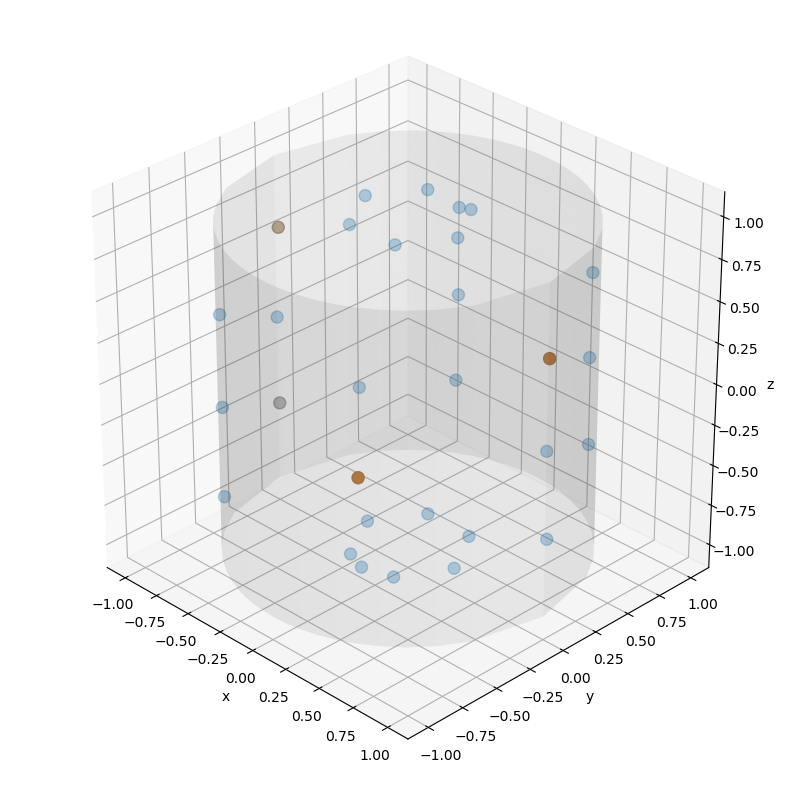

In [126]:
N_v = 5 #number of vertical samples
N_h = 6 #number of horiz. samples (must be even)
N = N_v*N_h #total number of points

#physical properties of cylinder
mu = 0.1
r = 1
h = 2
G, p = sample_points(N_v,N_h,h,r,0.02)

#define task vector weightings
w = zeros(12)
#w[2] = 1 #+Fy
#w[6] = 1 #+Mz
w = ones(12)/12 #volume maximization
input = torch.from_numpy(w).float()

scores = classifier_model(input).cpu().detach().numpy()[:]
strat = argmax(scores)
int_vals = assign_dict[strat]

#int_vals = del.value

#plot solution
len = 100
inds = findall(int_vals .>= 1.0-0.1)
x = r*collect(-1:0.1:1)
z = h/2*collect(-1:0.1:1)'
y = sqrt.(r^2 .- x.^2)

x_s = randn(100)
y_s = randn(100)
z_s = randn(100)

X = repeat(x,1,length(z))
Y = repeat(y,1,length(z))
Z = repeat(z,length(x),1)

PyPlot.figure(figsize=(10,10))
PyPlot.surf(X,Y,Z, color="grey",alpha=0.1)
PyPlot.surf(X,-Y,Z,color="grey",alpha=0.1)
PyPlot.xlabel("x")
PyPlot.ylabel("y")
PyPlot.zlabel("z")
points = hcat(p[inds]...)
all_points = hcat(p...)
PyPlot.scatter3D(all_points[1,:],all_points[2,:],all_points[3,:],alpha=0.3,s=75)
PyPlot.scatter3D(points[1,:],points[2,:],points[3,:],s=75)
ax = PyPlot.gca()
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.zaxis.set_tick_params(labelsize=10)
ax.view_init(elev=30,azim=-45)
PyPlot.savefig(string("plots/",system,"_visualization_+Mz.pdf"))

# Plot results

In [4]:
fn_results = "models/mlopt_model_manipulation_20200402_1427_3-layers_32-neurons_results.jld"
fn_dict = load(fn_results)

classifier_percentage = fn_dict["classifier_percentage"]
mip_percentage = fn_dict["mip_percentage"]
regressor_percentage = fn_dict["regressor_percentage"]

costs_classifier = fn_dict["costs_classifier"]
costs_IP = fn_dict["costs_IP"]
costs_regressor = fn_dict["costs_regressor"]

costs_ratios_classifier = fn_dict["costs_ratios_classifier"]
costs_ratios_regressor = fn_dict["costs_ratios_regressor"]

solve_times_classifier = fn_dict["solve_times_classifier"]
solve_times_IP = fn_dict["solve_times_IP"]
solve_times_regressor = fn_dict["solve_times_regressor"]

num_solves_classifier = fn_dict["num_solves_classifier"]
num_solves_IP = fn_dict["num_solves_IP"]
num_solves_regressor = fn_dict["num_solves_regressor"]
 
costs_rand = fn_dict["costs_rand"]
costs_ratios_rand = fn_dict["costs_ratios_rand"]
costs_mode = fn_dict["costs_mode"]
costs_ratios_mode = fn_dict["costs_ratios_mode"];

In [5]:
sns.set(font_scale=2., font="serif", style="whitegrid")

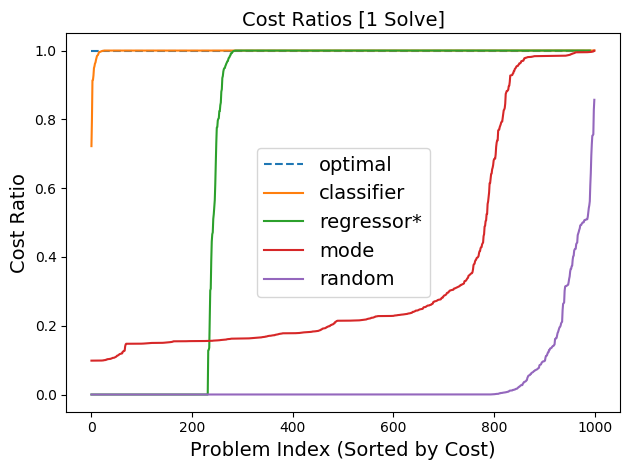

In [11]:
PyPlot.plot([0,length(costs_ratios_classifier)],[1.0,1.0],label="optimal",linestyle="--")
PyPlot.plot(sort(costs_ratios_classifier),label="classifier")
PyPlot.plot(sort(costs_ratios_regressor),label="regressor*")
PyPlot.plot(sort(costs_ratios_mode),label="mode")
PyPlot.plot(sort(costs_ratios_rand),label="random")
PyPlot.xlabel("Problem Index (Sorted by Cost)", fontsize=14)
PyPlot.ylabel("Cost Ratio", fontsize=14)
PyPlot.title("Cost Ratios [$n_evals Solve]", fontsize=14)

PyPlot.legend(bbox_to_anchor=(1.02,1.),prop=Dict("size"=>14))
PyPlot.legend(loc=0,prop=Dict("size"=>14))
# PyPlot.gcf().subplots_adjust(left=0.15)
PyPlot.tight_layout()
PyPlot.savefig(string("plots/",system,"_cost_comparison.pdf"))

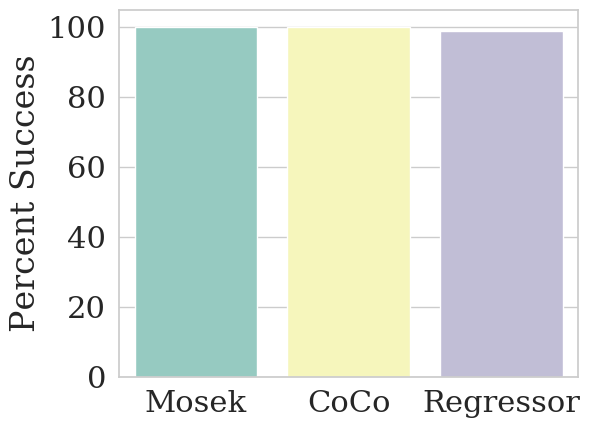

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[6]:4
└ @ Core In[6]:4
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[6]:4
└ @ Core In[6]:4


In [6]:
results = DataFrame()
results.Policy = [ "Mosek","CoCo","Regressor"]
results.Success = [mip_percentage, classifier_percentage, regressor_percentage]

ax1 = sns.barplot(x=results[:Policy], y=results[:Success], palette="Set3")
ax1.set(xlabel="", ylabel="Percent Success")
# PyPlot.gcf().subplots_adjust(left=0.15)
PyPlot.tight_layout()

figure = ax1.get_figure()
figure.savefig(string("plots/",system,"_percent_success.pdf"))

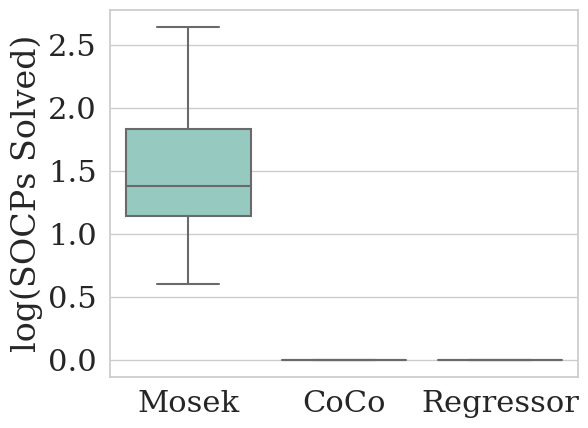

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[7]:10
└ @ Core In[7]:10
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[7]:10
└ @ Core In[7]:10


In [7]:
results = DataFrame()
results.Policy = vcat(fill("Mosek", length(num_solves_IP)),
                        fill("CoCo", length(num_solves_classifier)),
                        fill("Regressor", length(num_solves_regressor)))
results.Solves = vcat(log10.(num_solves_IP.+1), 
                        log10.(num_solves_classifier), 
                        log10.(num_solves_regressor))

flierprops = Dict("alpha"=>0.2)
ax2 = sns.boxplot(x=results[:Policy], y=results[:Solves], palette="Set3")
ax2.set(xlabel="", ylabel="log(SOCPs Solved)")
# PyPlot.gcf().subplots_adjust(left=0.15)
PyPlot.tight_layout()

figure = ax2.get_figure()
figure.savefig(string("plots/",system,"_solved.pdf"));

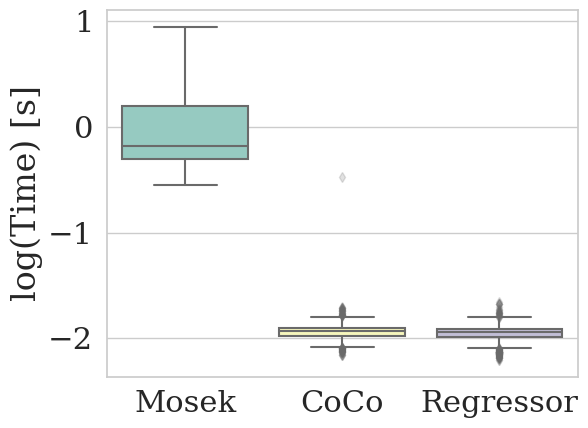

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[11]:8
└ @ Core In[11]:8
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[11]:8
└ @ Core In[11]:8


In [11]:
results = DataFrame()
results.Policy = vcat(fill("Mosek", length(solve_times_IP)),
                        fill("CoCo", length(solve_times_classifier)),
                        fill("Regressor", length(solve_times_regressor)))
results.Time = vcat(log10.(solve_times_IP), log10.(solve_times_classifier), log10.(solve_times_regressor))

flierprops = Dict("alpha"=>0.2)
ax3 = sns.boxplot(x=results[:Policy], y=results[:Time], palette="Set3", flierprops=flierprops)
ax3.set(xlabel="", ylabel="log(Time) [s]")
# PyPlot.gcf().subplots_adjust(left=0.15)
PyPlot.tight_layout()

figure = ax3.get_figure()
figure.savefig(string("plots/",system,"_time.pdf"));

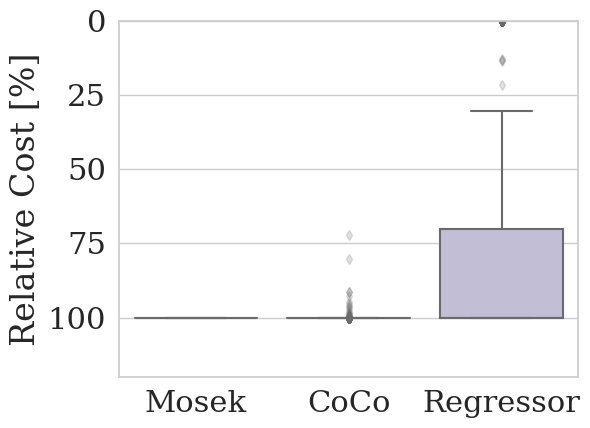

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[13]:8
└ @ Core In[13]:8
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[13]:8
└ @ Core In[13]:8


In [13]:
results = DataFrame()
results.Policy = vcat("Mosek",
                        fill("CoCo", length(costs_ratios_classifier)),
                        fill("Regressor", length(costs_ratios_regressor)))
results.Costs = 100 .* [1; costs_ratios_classifier; costs_ratios_regressor]

flierprops = Dict("alpha"=>0.2)
ax4 = sns.boxplot(x=results[:Policy], y=results[:Costs], palette="Set3", flierprops=flierprops)
ax4.set(xlabel="", ylabel="Relative Cost [%]", ylim=(0,120))
ax4.invert_yaxis()
# PyPlot.gcf().subplots_adjust(left=0.15)
PyPlot.tight_layout()

figure = ax4.get_figure()
figure.savefig(string("plots/",system,"_cost.pdf"));